# Road Signs classification using PyTorch and the GTSRB dataset

In [96]:
%%javascript
var rate = 0;
// apply setting to  all current CodeMirror instances
IPython.notebook.get_cells().map(
    function(c) {  return c.code_mirror.options.cursorBlinkRate=rate;  }
);

// make sure new CodeMirror instance also use this setting
CodeMirror.defaults.cursorBlinkRate=rate;

<IPython.core.display.Javascript object>

In [97]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset


In [118]:
class RoadSignsDataset(Dataset):
    def __init__(self, datasets_path, csv_name):
        self.metadatas = pd.read_csv(datasets_path + '/' + csv_name)
        self.datasets_path = datasets_path
        self.transform = torch.nn.Sequential(
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        )
    
    def __len__(self):
        return len(self.metadatas.index)
    
    def __getitem__(self, idx):
        img_path = self.metadatas.loc[idx, "Path"]
        image = read_image(self.datasets_path + '/' + img_path).float()
        image = self.transform(image)
        label = self.metadatas.loc[idx, "ClassId"]
        return image, label

In [119]:
test = pd.read_csv("datasets/Test.csv")
test = test[["Width", "Height", "ClassId", "Path"]]
test["Ratio"] = test["Width"] / test["Height"]
a = test[abs(test["Ratio"] - 1) < 0.2]
print(len(a))
print(len(test))

12386
12630


In [120]:
from torch.utils.data import DataLoader
from torchvision import transforms

test_data = RoadSignsDataset("datasets", "Test.csv")
train_data = RoadSignsDataset("datasets", "Train.csv")

test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[1111.4192, 1136.3572, 1131.5289],
         [1111.4192, 1136.3572, 1131.5289],
         [1111.4192, 1136.3572, 1131.5289],
         ...,
         [ 572.8929,  437.9846,  348.2315],
         [ 480.4855,  399.9341,  318.1877],
         [ 423.2080,  375.2844,  300.9514]],

        [[1111.4192, 1136.3572, 1131.5289],
         [1111.4192, 1136.3572, 1131.5289],
         [1111.4192, 1136.3572, 1131.5289],
         ...,
         [ 572.8929,  437.9846,  348.2315],
         [ 480.4855,  399.9341,  318.1877],
         [ 423.2080,  375.2844,  300.9514]],

        [[1111.4192, 1136.3572, 1131.5289],
         [1111.4192, 1136.3572, 1131.5289],
         [1111.4192, 1136.3572, 1131.5289],
         ...,
         [ 573.2368,  465.8156,  367.3918],
         [ 479.3378,  421.3610,  333.0975],
         [ 420.9344,  390.8056,  312.2310]],

        ...,

        [[ 242.5458,  255.6968,  215.4416],
         [ 247.3812,  267.0161,  235.3390],
         [ 252.2167,  278.3354,  255.2363],
         ...,


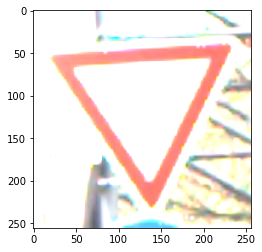

In [122]:
import matplotlib.pyplot as plt

batch_features, batch_labels = next(iter(train_dataloader))
img = batch_features[0].squeeze()
label = batch_labels[0]
print(img.permute(1, 2, 0))
plt.imshow(img.int().permute(1, 2, 0))
plt.show()